## DEM extraction

This is the presentation of the DEM gebco class in dem module.

In [1]:
#to use the full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

import pyresample

In [2]:
%matplotlib inline 

In [3]:
url = '/Users/brey/DATA/GEBCO_2014_2D.nc'

In [4]:
data = xr.open_mfdataset(url)

In [5]:
data

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 ...
Data variables:
    elevation  (lat, lon) float32 dask.array<shape=(21600, 43200), chunksize=(21600, 43200)>
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

In [6]:
#lon range
data.attrs

OrderedDict([(u'Conventions', u'CF-1.6'), (u'title', u'The GEBCO_2014 Grid - a continuous terrain model for oceans and land at 30 arc-second intervals.'), (u'institution', u'On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data are held at the British Oceanographic Data Centre (BODC).'), (u'source', u'The bathymetric portion of the GEBCO_2014 Grid was largely developed from a database of ship track soundings with interpolation between soundings guided by satellite-derived gravity data. In areas where they improve on this existing base grid, data sets developed by other methods are included. Recognising the importance of local expertise when building a global bathymetric model, GEBCO have been working with regional mapping groups to improve the existing GEBCO grid. Details about the development of the grid and the data sets included can be found in the documentation that accompanies the data set. With the exception of polar regions, land data are based on the 1-km a

In [7]:
data.variables.keys()

[u'elevation', u'lat', u'lon']

In [8]:
#define the lat/lon window and time frame of interest
minlon = 0. 
maxlon =  13.
minlat = 54.5
maxlat = 66.5

In [13]:
if minlon < -180: minlon = minlon + 360.
      
if maxlon < -180: maxlon = maxlon + 360.
    

In [9]:
mc = np.mean([minlon,maxlon])
mc

6.5

In [10]:
mt = np.mean([minlat,maxlat])
mt

60.5

In [12]:
data.lon.min()

<xarray.DataArray 'lon' ()>
array(-179.995833)

In [14]:
i0=np.abs(data.lon.data-minlon).argmin()
i1=np.abs(data.lon.data-maxlon).argmin()

      
j0=np.abs(data.lat.data-minlat).argmin()
j1=np.abs(data.lat.data-maxlat).argmin()
      
dem = (
          data[data.data_vars.keys()[0]]
          .isel(lon=slice(i0,i1),lat=slice(j0,j1))
          )


In [15]:
i0,i1,j0,j1

(21599, 23159, 17340, 18779)

In [16]:
xx,yy = np.meshgrid(dem.lon,dem.lat)


In [17]:
gebco = xr.Dataset({'val': (['dlat', 'dlon'],  dem), 
                    'dlons': (['i', 'j'], xx),   
                    'dlats': (['i', 'j'], yy)}, 
                    coords={'dlon': ('dlon', xx[0,:]),   
                            'dlat': ('dlat', yy[:,0])})         

## Resampling on Grid

In [18]:
resolution = .5

In [19]:
ni=int(round((maxlon-minlon)/resolution)) #these are cell numbers
nj=int(round((maxlat-minlat)/resolution))
  
maxlon=minlon+ni*resolution #adjust max lon to much the grid
maxlat=minlat+nj*resolution

        # set the grid 
x=np.linspace(minlon,maxlon,ni)
y=np.linspace(minlat,maxlat,nj)
gx,gy=np.meshgrid(x,y)


In [21]:
grid_x = gx
grid_y = gy
# resample on the given grid
              
orig = pyresample.geometry.SwathDefinition(lons=xx,lats=yy) # original points
targ = pyresample.geometry.SwathDefinition(lons=grid_x,lats=grid_y) # target grid
       


In [24]:
itopo = pyresample.kd_tree.resample_nearest(orig,dem.values,targ,radius_of_influence=50000,fill_value=np.nan,nprocs=4)

In [25]:
if len(grid_x.shape) > 1:         
    dem = xr.Dataset({'ival': (['ilat', 'ilon'],  itopo), 
                      'ilons': (['k', 'l'], grid_x),   
                      'ilats': (['k', 'l'], grid_y)}, 
                      coords={'ilon': ('ilon', grid_x[0,:]),   
                              'ilat': ('ilat', grid_y[:,0])})         

elif len(grid_x.shape) == 1:
    dem = xr.Dataset({'ival': (['k'],  itopo), 
                      'ilons': (['k'], grid_x),   
                      'ilats': (['k'], grid_y)}
                             )
                         
gebco = xr.merge([gebco,dem])
         


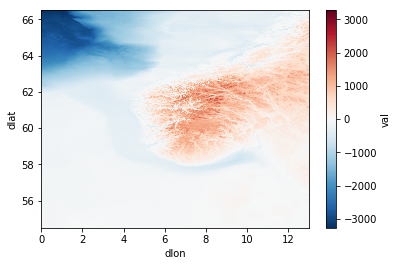

In [26]:
gebco.val.plot()

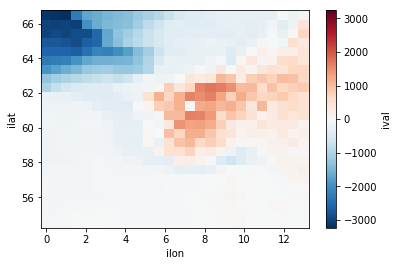

In [27]:
gebco.ival.plot()

<IPython.core.display.Javascript object>


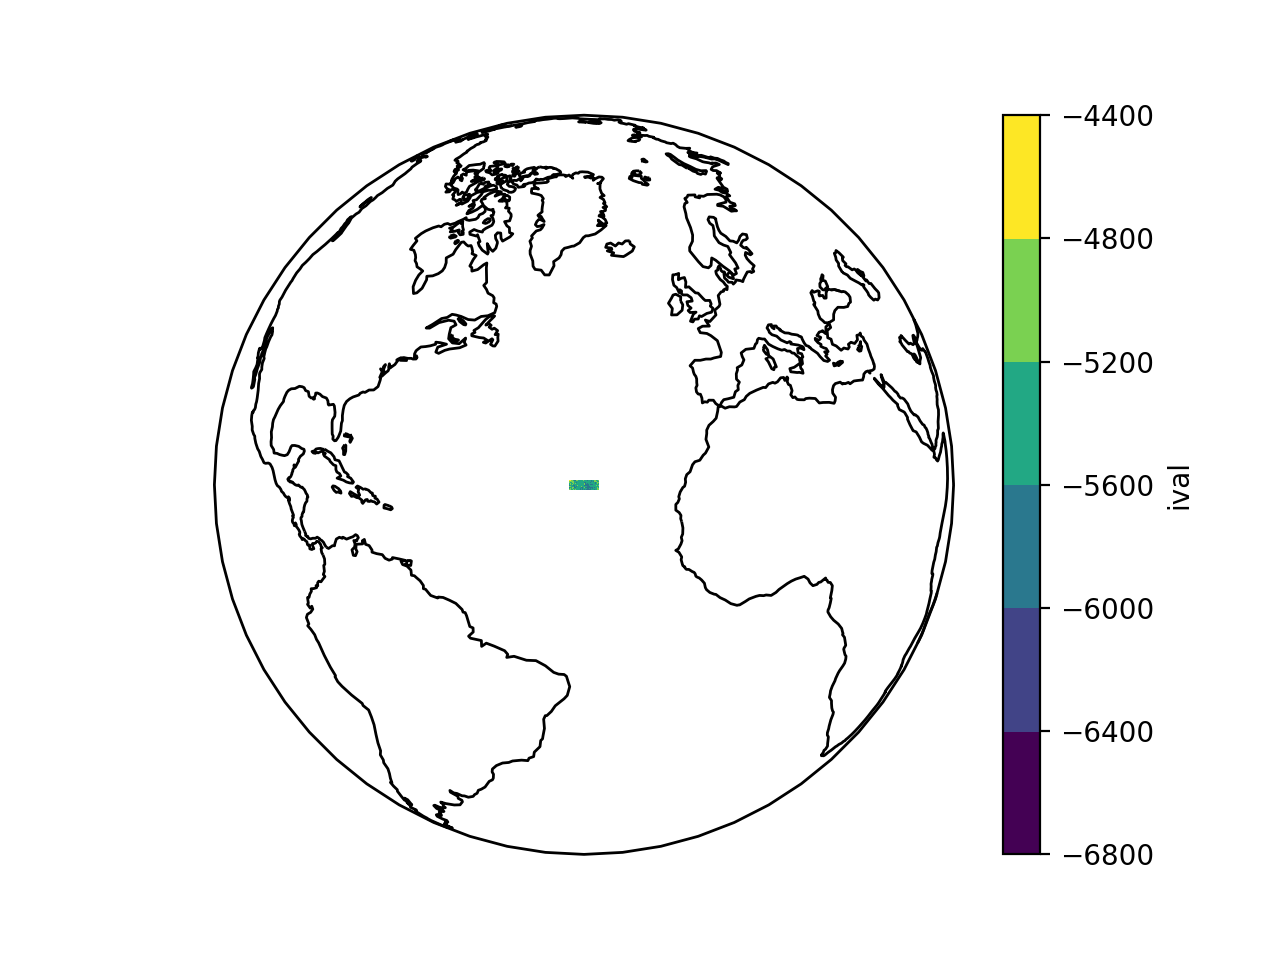

In [29]:
fig, ax = plt.subplots()

ax = plt.axes(projection=ccrs.Orthographic(mc, mt))

emodnet.ival.plot.contourf(ax=ax, transform=ccrs.PlateCarree());

ax.set_global()
ax.coastlines()